We first install and import necessary packages.

In [1]:
# !pip install torch
# !pip install swig
# !pip install gymnasium
# !pip install gymnasium[box2d] 
# !pip install stable-baselines3
# !pip install pygame
# !pip install ufal.pybox2d

In [2]:
import gymnasium as gym

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as functional

import matplotlib.pyplot as plt

## Lunar Lander

Next, we instantiate the [Lunar Lander environment](https://www.gymlibrary.dev/environments/box2d/lunar_lander/) from OpenAI Gym and gain a quick understanding of its key variables and methods.

The Lunar Lander environment models a rocket that needs to land on the moon. Follow the hyperlinks to learn more about the envionment [Acrobot environment](https://www.gymlibrary.dev/environments/box2d/lunar_lander/). In this assignment, we will use the Continuous (v2) version of the environment in which both the state and action spaces are continuous.

![](https://www.gymlibrary.dev/_images/lunar_lander.gif)

In [3]:
env = gym.make("LunarLanderContinuous-v2")

#### States

OpenAI Gym environments do not explicitly provide state but instead provide observation. In the Lunar Lander environment, the state and observation are identical. The state of the Lander is a 8-dimensional vector: the coordinates of the lander in x and y, its linear velocities in x and y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.


In [4]:
print(f"Number of state features: {env.observation_space.shape[0]}")

Number of state features: 8


#### Actions

The action space is also continous and includes two features. The first coordinate of an action determines the throttle of the main engine, while the second coordinate specifies the throttle of the lateral boosters.

Given an action `np.array([main, lateral])`, the main engine will be turned off completely if `main < 0` and the throttle scales affinely from 50% to 100% for `0 <= main <= 1` (i.e., the main engine doesn’t work with less than 50% power). Similarly, if `-0.5 < lateral < 0.5`, the lateral boosters will not fire at all. If `lateral < -0.5`, the left booster will fire, and if `lateral > 0.5`, the right booster will fire. Again, the throttle scales affinely from 50% to 100% between -1 and -0.5 (and 0.5 and 1, respectively)

In [5]:
print(f"Number of action features: {env.action_space.shape[0]}")

Number of action features: 2


#### Transition and Reward Function

The transition and rewards functions for the environment are not explicitly represented as matrices or tensors. Instead the gym API provides access to the `step` method, which takes in as input an `action` and provides (among other things) an `observation` and `reward`. Also notice the `reset` method, which resets the MDP environment.

The following snippet describes the use of `step` and `reset` methods.

In [6]:
# Reset the environment
state = env.reset()
print(f"State: {state}")

# Select a random action to play
action = env.action_space.sample()
print(f"Action: {action}")

# Send this action to the environment to receive the next state and reward
next_state, reward, done, _, _ = env.step(action)
print(f"Next state: {next_state}")
print(f"Reward: {reward}")

State: (array([-0.00269032,  1.4067186 , -0.27251542, -0.1867361 ,  0.00312421,
        0.06172874,  0.        ,  0.        ], dtype=float32), {})
Action: [ 0.2064892  -0.81549114]
Next state: [-0.00535192  1.4025099  -0.27097046 -0.18707293  0.00788195  0.09516457
  0.          0.        ]
Reward: -0.15290034761616084


## Problem 1.1

Next, we will implement the general recipe of the DDPG algorithm to compute the optimal policy for the Lunar Lander.

#### Actor-Critic Networks

DDPG requires two networks: Actor and Critic. Let us know define these networks.

In [27]:
class Actor(nn.Module):
  """Actor Network as a Multi-Layer Perceptron."""

  def __init__(self, env, mlp_sizes=[256, 256]):
    """Initialize the Actor Network.

    Args:
        env: An OpenAI Gym environment.
        mlp_sizes: An array of integers. The length of array equals the number
            of hidden layers of the Multi-Layer Perceptron. Each element in the array
            equals the number of nodes in the corresponding layer.
    """
    super().__init__()
    ######## PUT YOUR CODE HERE ########
    # input layer
    self.input_layer = nn.Linear(env.observation_space.shape[0], mlp_sizes[0])

    # hidden layers
    self.hidden_layers = nn.ModuleList()
    for k in range(len(mlp_sizes) - 1):
        self.hidden_layers.append(nn.Linear(mlp_sizes[k], mlp_sizes[k+1]))

    # output layer
    self.output_layer = nn.Linear(mlp_sizes[len(mlp_sizes) - 1], env.action_space.shape[0])

    self.tanh = nn.Tanh()
    self.relu = nn.ReLU()
    ######## PUT YOUR CODE HERE ########

  def forward(self, x):
    """Implements the forward pass of the Actor Network.

    Args:
        x: Input to the Actor Network.

    Returns:
        Output of the Actor Network.
    """
    ######## PUT YOUR CODE HERE ########

    output = self.relu(self.input_layer(x))

    for layer in self.hidden_layers:
        output = layer(output)


    return self.tanh(self.output_layer(output))

    ######## PUT YOUR CODE HERE ########

In [28]:
class Critic(nn.Module):
  """Critic Network as a Multi-Layer Perceptron."""

  def __init__(self, env, mlp_sizes=[256, 256]):
    """Initialize the Critic Network.

    Args:
        env: An OpenAI Gym environment.
        mlp_sizes: An array of integers. The length of array equals the number
            of hidden layers of the Multi-Layer Perceptron. Each element in the array
            equals the number of nodes in the corresponding layer.
    """
    super().__init__()

    ######## PUT YOUR CODE HERE ########
    # input layer
    self.input_layer = nn.Linear(env.observation_space.shape[0] + env.action_space.shape[0], mlp_sizes[0])

    # hidden layers
    self.hidden_layers = nn.ModuleList()
    for k in range(len(mlp_sizes) - 1):
        self.hidden_layers.append(nn.Linear(mlp_sizes[k], mlp_sizes[k+1]))

    # output layer
    self.output_layer = nn.Linear(mlp_sizes[len(mlp_sizes) - 1], 1)

    self.relu = nn.ReLU()

    ######## PUT YOUR CODE HERE ########

  def forward(self, x):
    """Implements the forward pass of the Critic Network.

    Args:
        x: Input to the Critic Network.

    Returns:
        Output of the Critic Network.
    """
    ######## PUT YOUR CODE HERE ########

    output = self.relu(self.input_layer(x))

    for layer in self.hidden_layers:
        output = self.relu(layer(output))


    return self.output_layer(output)

    ######## PUT YOUR CODE HERE ########

#### Replay Buffer

DDPG requires a data structure to store the agent's experiences: Replay Buffer. Let us now define this data structure.

In [29]:
class ReplayBuffer:
  """A buffer to store agent's experiences."""

  def __init__(self, env, buffer_size):
    """Initialize a buffer to store agent's experiences.

    Args:
        env: An OpenAI Gym environment.
        buffer_size: An integer. The size of the buffer.
    """
    observation_n = env.observation_space.shape[0]
    action_n = env.action_space.shape[0]

    self.buffer_size = buffer_size
    self.observations = np.zeros((self.buffer_size, observation_n), dtype=np.float32)
    self.next_observations = np.zeros((self.buffer_size, observation_n), dtype=np.float32)
    self.actions = np.zeros((self.buffer_size, action_n), dtype=np.float32)
    self.rewards = np.zeros((self.buffer_size,), dtype=np.float32)
    self.dones = np.zeros((self.buffer_size,), dtype=np.float32)

    self.size = 0
    self.pos = 0

  def add(self, observation, next_observation, action, reward, done):
    """Add an experience to the buffer.

    Args:
        observation: the current environment state
        next_observation: the state after executing the action
        action: the action executed in the state
        reward: the reward received after executing the action
        done: Boolean denoting whether the task is completed.
    """
    self.observations[self.pos] = observation
    self.next_observations[self.pos] = next_observation
    self.actions[self.pos] = action
    self.rewards[self.pos] = reward
    self.dones[self.pos] = 1.0 if done else 0.0

    self.pos += 1
    if self.size < self.buffer_size:
      self.size += 1
    if self.pos == self.buffer_size:
      self.pos = 0

  def sample(self, batch_size):
    """Sample a mini-batch of experiences from the replay buffer.
    For ease of implementation, we sample with replacement.

    Args:
        batch_size: An integer. The size of the mini-batch.

    Returns:
        Randomly sampled experiences from the replay buffer.
    """
    indices = np.random.randint(self.size, size=batch_size)
    observations = torch.from_numpy(self.observations[indices])
    next_observations = torch.from_numpy(self.next_observations[indices])
    actions = torch.from_numpy(self.actions[indices])
    rewards = torch.from_numpy(self.rewards[indices])
    dones = torch.from_numpy(self.dones[indices])

    return observations, next_observations, actions, rewards, dones

#### Exploration schedule

In general, it is useful to explore more initially (when the agent is far from the optimal policy) and less later on in the learning process. To implement this, we can implement a schedule for epsilon.

Similar to the Actor and Critic networks and replay buffer architectures, several choices exist for determining the epsilon schedule. We will use a simple linear scheduler to decay epsilon as agent gains more experience.

In [30]:
def linear_schedule_for_epsilon(initial_value, final_value, duration, timestep):
  """Implements a linear scheduler for epsilon.

  Args:
      initial_value: (float) Initial value of epsilon.
      final_value: (float) Final value of epsilon.
      duration: (int) Duration over which to decay epsilon from its initial to final value.
      timestep: (int) The current time step.

  Returns:
      Value of epsilon at the given timestep.
  """
  slope = (final_value - initial_value) / duration
  return max(slope * timestep + initial_value, final_value)

#### Target Networks
In DDPG, we will update the target network in each iteration of the algorithm. A utility function to update the weights of the target network is provided below.

In [31]:
def update_weights(src, target, tau=1.0):
  """Utility function to update the target network using Polyak averaging.

  Args:
    src: (target network) source network
    target: (neural network) target network
    tau: (float) Polyak factor
  """

  for target_param, param in zip(target.parameters(), src.parameters()):
    target_param.data.copy_(
        target_param.data * (1.0 - tau) + param.data * tau
    )

#### DDPG algorithm

Now that we have all the building blocks, we will implement the DDPG algorithm.

We will use the AgentBase class from Assignment 2 to help us with the implementation.

In [32]:
class AgentBase:
  def __init__(self, env):
    self.env = env
    self.policy = self.make_policy()
    self.behavior_policy = self.make_behavior_policy()

  def make_policy(self):
    """
    Return a policy function that will be used for evaluation. The policy
    takes observation as input and return action
    """
    raise NotImplementedError

  def make_behavior_policy(self):
    """
    Similar to make_policy, it returns a policy function. But this one used
    for interaction with the environment.
    """
    raise NotImplementedError

  def run_episode(self, episode_policy):
    """
    Generate one episode with the given policy
    """
    episode = []
    done = False
    obs = self.env.reset()[0]
    episode_return = 0
    while not done:
      action = episode_policy(obs)
      next_obs, reward, done, truncated, _ = self.env.step(action)
      done = done or truncated
      episode.append([obs, action, reward, next_obs, done])
      obs = next_obs
      episode_return += reward

    return (episode, episode_return)

  def evaluate(self, num_eval_episodes=1000, plot_title="Evaluation"):
    """Evaluates the agent."""
    list_returns = []
    list_average_returns = []
    average_return = 0
    for episode_idx in range(num_eval_episodes):
      _, episode_return = self.run_episode(self.policy)
      average_return += (1. / (episode_idx+1)) * (episode_return - average_return)
      list_returns.append(episode_return)
      list_average_returns.append(average_return)

    print(f"Average reward {round(average_return, 3)}")
    plt.plot(list_returns,'^',label="Return")
    plt.plot(list_average_returns,'r',label="Average Return")
    plt.ylabel('Return')
    plt.xlabel('Episode#')
    plt.title(plot_title)
    plt.legend()
    plt.ylim(-501, 0.0)
    plt.show()

In [33]:
class DDPG(AgentBase):
  """Implements DDPG."""

  def __init__(
    self,
    env,
    actor_lr=0.001,
    critic_lr=0.001,
    total_timesteps=100000,
    buffer_size=100000,
    warmup_steps=10000,
    batch_size=100,
    tau=0.005,
    noise_std=0.05,
  ):
    """Initializes the Agent.
    Args:
        env: An OpenAI Gym environment.
        actor_lr: (float) Learning rate of actor
        critic_lr: (float) Learning rate of critic
        total_timesteps: (integer) The number of timesteps in training
        buffer_size: (integer) Size of the replay buffer.
        warmup_steps: (integer) Size of data for pre-filling buffer
        batch_size: (integer) Size of the mini batch.
        tau: (float) The amount of update to target actor/critic
        noise_std: (float) Initial noise level for exploration.
    """
    super().__init__(env=env)

    self.gamma = 0.99 # Assume a discount factor of 0.99
    self.env = env
    self.actor_lr = actor_lr
    self.critic_lr = critic_lr
    self.total_timesteps = total_timesteps
    self.buffer_size = buffer_size
    self.warmup_steps = warmup_steps
    self.batch_size = batch_size
    self.tau = tau
    self.noise_std = noise_std

    # Create actor and critic
    ######## PUT YOUR CODE HERE ########
    self.actor = Actor(env)
    self.actor_target = Actor(env)
    self.critic = Critic(env)
    self.critic_target = Critic(env)
    ######## PUT YOUR CODE HERE ########

    # Copy weights to target networks
    update_weights(self.actor, self.actor_target)
    update_weights(self.critic, self.critic_target)

    # Create optimizers
    ######## PUT YOUR CODE HERE ########
    self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=self.actor_lr)
    self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=self.critic_lr)
    ######## PUT YOUR CODE HERE ########

    # Create replay buffer
    ######## PUT YOUR CODE HERE ########
    self.replay_buffer = ReplayBuffer(env, buffer_size)
    ######## PUT YOUR CODE HERE ########

    # Create variables for logging
    self.obs = env.reset()[0]
    self.current_step = 0
    self.list_returns = []
    self.list_average_returns = []
    self.average_return = 0.
    self.list_moving_average_returns = []

    self.num_actions = env.action_space.shape[0]

        # Create exploration scheduler
  #   self.epsilon_scheduler = lambda current_step: linear_schedule_for_epsilon(
  #       1.0, 0.01, total_timesteps, current_step)


  # @property
  # def epsilon(self):
  #     return self.epsilon_scheduler(self.current_step)


  def make_policy(self):
    def policy_func(observation):
      ######## PUT YOUR CODE HERE ########
      observation = torch.tensor(observation)

      output = self.actor.forward(observation).detach().numpy()

      return output
      ######## PUT YOUR CODE HERE ########

    return policy_func

  def make_behavior_policy(self):
    def policy_func(observation):
      ######## PUT YOUR CODE HERE ########
      observation = torch.tensor(observation)

      output = self.actor.forward(observation).detach().numpy() + np.random.normal(scale=self.noise_std**0.5, size=2)

      output[0] = np.clip(output[0], 0, 1)
      output[1] = np.clip(output[1], -1, 1)

      return output
      ######## PUT YOUR CODE HERE ########

    return policy_func

  def update(self):
    if self.current_step > self.warmup_steps:
      ######## PUT YOUR CODE HERE ########
      # Sample a batch
      observations, next_observations, actions, rewards, dones = self.replay_buffer.sample(self.batch_size)
      rewards = rewards.unsqueeze(1)
      dones = dones.unsqueeze(1)


      # Get target values
      input_ = torch.cat((next_observations, self.actor_target.forward(next_observations)), dim=1)
      target = rewards + self.gamma * self.critic_target.forward(input_) * (1.0 - dones)

      # Decay learning rate
      # self.actor_lr = self.actor_lr * 0.999
      # self.critic_lr = self.critic_lr * 0.999

      # Update critic
      self.critic_optim.zero_grad()
      loss_fn = nn.MSELoss()
      input_ = torch.cat((observations, actions), dim=1)
      out = self.critic.forward(input_)
      loss1 = loss_fn(out, target.detach())
      loss1.backward()
      self.critic_optim.step()

      # Update actor
      self.actor_optim.zero_grad()
      input_ = torch.cat((observations, self.actor.forward(observations)), dim=1)
      out = -self.critic.forward(input_)
      loss2 = out.mean()
      loss2.backward()
      self.actor_optim.step()

      ######## PUT YOUR CODE HERE ########

    # Update Target Network
    update_weights(self.actor, self.actor_target, self.tau)
    update_weights(self.critic, self.critic_target, self.tau)


  def train(self, make_plot=False):
    episode_return = 0.
    while self.current_step < self.total_timesteps:

      # Interact with env
      action = self.behavior_policy(self.obs)
      next_obs, reward, done, truncated, info = self.env.step(action)
      episode_return += reward
      done = done or truncated

      if done:
        # Store the return for evaluation
        self.list_returns.append(episode_return)
        episode_return = 0.
        self.average_return = np.mean(np.asarray(self.list_returns))
        self.list_average_returns.append(self.average_return)

        if len(self.list_average_returns) > 20:
          self.list_moving_average_returns.append(np.mean(self.list_returns[-20:]))
        else:
          self.list_moving_average_returns.append(self.average_return)

      # Save data into buffer
      self.replay_buffer.add(self.obs, next_obs, action, reward, done)

      # Update networks
      self.update()

      # Prepare for next iteration
      if done:
        self.obs = env.reset()[0]
      else:
        self.obs = next_obs

      if self.current_step % 1000 == 999:
        print(f"Timestep: {self.current_step+1}, episode reward (moving average, 20 episodes): {round(self.list_moving_average_returns[-1],2)}")
      self.current_step += 1

    if make_plot:
      plt.plot(self.list_returns,'^',label="Return")
      plt.plot(self.list_average_returns,'r',label="Average Return (all episodes)")
      plt.plot(self.list_moving_average_returns,'b',label="Average Return (last 20 episodes)")
      plt.ylabel('Return')
      plt.xlabel('Episode#')
      plt.title('Performance during training')
      plt.ylim(-501, 300)
      plt.legend()
      plt.show()
      

#### Training the Agent

Having implemented the agent, now we will train it using the default hyperparameters provided in the class definition and observe its performance.

In [34]:
env = gym.make("LunarLanderContinuous-v2")

Timestep: 1000, episode reward (moving average, 20 episodes): -201.2
Timestep: 2000, episode reward (moving average, 20 episodes): -171.83
Timestep: 3000, episode reward (moving average, 20 episodes): -177.86
Timestep: 4000, episode reward (moving average, 20 episodes): -190.41
Timestep: 5000, episode reward (moving average, 20 episodes): -178.67
Timestep: 6000, episode reward (moving average, 20 episodes): -188.41
Timestep: 7000, episode reward (moving average, 20 episodes): -186.73
Timestep: 8000, episode reward (moving average, 20 episodes): -166.96
Timestep: 9000, episode reward (moving average, 20 episodes): -163.83
Timestep: 10000, episode reward (moving average, 20 episodes): -172.2
Timestep: 11000, episode reward (moving average, 20 episodes): -253.71
Timestep: 12000, episode reward (moving average, 20 episodes): -292.77
Timestep: 13000, episode reward (moving average, 20 episodes): -335.59
Timestep: 14000, episode reward (moving average, 20 episodes): -362.59
Timestep: 15000, 

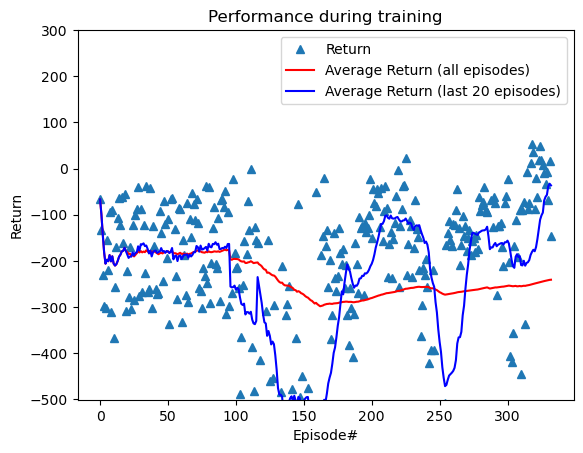

In [35]:
agent_001 = DDPG(env)
agent_001.train(make_plot=True)

## Problem 1.2

The performance of RL algorithms typically varies across runs. Report results of five runs of your algorithm and summarize the performance in a single plot.

In [16]:
######## PUT YOUR CODE HERE ########
agent_002 = DDPG(env, total_timesteps=100000)
agent_002.train()

agent_003 = DDPG(env, total_timesteps=100000)
agent_003.train()

agent_004 = DDPG(env, total_timesteps=100000)
agent_004.train()

agent_005 = DDPG(env, total_timesteps=100000)
agent_005.train()

######## PUT YOUR CODE HERE ########

Timestep: 1000, episode reward (moving average, 20 episodes): -226.49
Timestep: 2000, episode reward (moving average, 20 episodes): -258.19
Timestep: 3000, episode reward (moving average, 20 episodes): -251.42
Timestep: 4000, episode reward (moving average, 20 episodes): -288.13
Timestep: 5000, episode reward (moving average, 20 episodes): -254.84
Timestep: 6000, episode reward (moving average, 20 episodes): -241.05
Timestep: 7000, episode reward (moving average, 20 episodes): -191.03
Timestep: 8000, episode reward (moving average, 20 episodes): -221.97
Timestep: 9000, episode reward (moving average, 20 episodes): -248.15
Timestep: 10000, episode reward (moving average, 20 episodes): -246.19
Timestep: 11000, episode reward (moving average, 20 episodes): -227.35
Timestep: 12000, episode reward (moving average, 20 episodes): -193.65
Timestep: 13000, episode reward (moving average, 20 episodes): -203.6
Timestep: 14000, episode reward (moving average, 20 episodes): -224.94
Timestep: 15000,

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


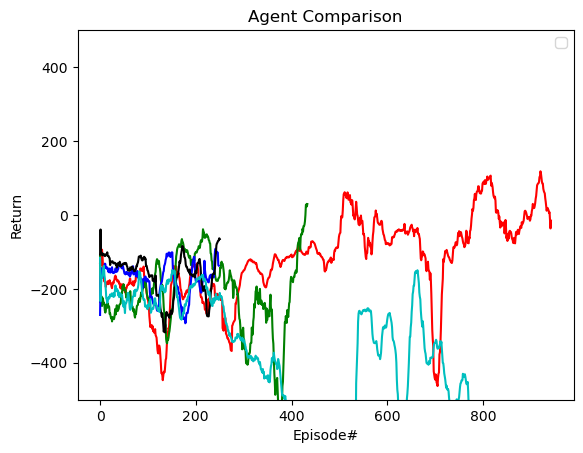

In [21]:
plt.plot(agent_001.list_moving_average_returns[:100000],'r')
plt.plot(agent_002.list_moving_average_returns,'g')
plt.plot(agent_003.list_moving_average_returns,'b')
plt.plot(agent_004.list_moving_average_returns,'k')
plt.plot(agent_005.list_moving_average_returns,'c')

plt.ylabel('Return')
plt.xlabel('Episode#')
plt.title('Agent Comparison')
plt.ylim([-500, 500])
plt.legend()
plt.show()

## Problem 1.3

Select any one hyperparameter of the algorithm and study its effect on the agent's performance.
You should try at least five different values of this hyperparameter and report on the observed performance. In a single plot, show the performance of the agent for different values of hyperparameter.  


In [22]:
######## PUT YOUR CODE HERE ########

agent_006 = DDPG(env, total_timesteps=100000, actor_lr=0.1, critic_lr=0.1)
agent_006.train()

agent_007 = DDPG(env, total_timesteps=100000, actor_lr=0.01, critic_lr=0.01)
agent_007.train()

agent_008 = DDPG(env, total_timesteps=100000, actor_lr=0.0001, critic_lr=0.0001)
agent_008.train()

agent_009 = DDPG(env, total_timesteps=100000, actor_lr=0.00001, critic_lr=0.00001)
agent_009.train()

######## PUT YOUR CODE HERE ########

Timestep: 1000, episode reward (moving average, 20 episodes): -181.37
Timestep: 2000, episode reward (moving average, 20 episodes): -205.56
Timestep: 3000, episode reward (moving average, 20 episodes): -191.91
Timestep: 4000, episode reward (moving average, 20 episodes): -181.31
Timestep: 5000, episode reward (moving average, 20 episodes): -210.42
Timestep: 6000, episode reward (moving average, 20 episodes): -196.46
Timestep: 7000, episode reward (moving average, 20 episodes): -179.21
Timestep: 8000, episode reward (moving average, 20 episodes): -159.81
Timestep: 9000, episode reward (moving average, 20 episodes): -154.49
Timestep: 10000, episode reward (moving average, 20 episodes): -163.79
Timestep: 11000, episode reward (moving average, 20 episodes): -665.16
Timestep: 12000, episode reward (moving average, 20 episodes): -1070.98
Timestep: 13000, episode reward (moving average, 20 episodes): -1117.35
Timestep: 14000, episode reward (moving average, 20 episodes): -1082.28
Timestep: 15

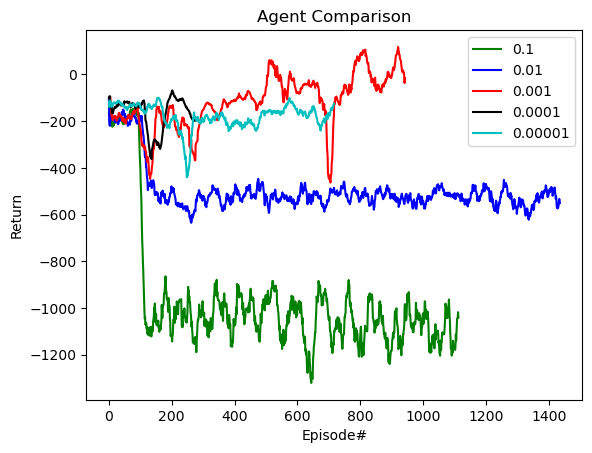

In [25]:

plt.plot(agent_006.list_moving_average_returns,'g', label="0.1")
plt.plot(agent_007.list_moving_average_returns,'b', label="0.01")
plt.plot(agent_001.list_moving_average_returns,'r', label="0.001")
plt.plot(agent_008.list_moving_average_returns,'k', label="0.0001")
plt.plot(agent_009.list_moving_average_returns,'c', label="0.00001")

plt.ylabel('Return')
plt.xlabel('Episode#')
plt.title('Agent Comparison')
plt.legend()
plt.show()

## Problem 1.4

While applying RL in real world, you may consider the use of off-the-shelf implementation of RL algorithms. The package [Stable Baselines 3](stable-baselines3.readthedocs.io/) aims to provide a set of reliable implementations of RL algorithms in PyTorch.

Familiarize yourself with this package and use its implementation of DDPG to learn the optimal policy for the Lunar Lander environment.

In a single plot, compare the performance of your implementation of the algorithm in Problem 1.1. with the one that you implemented above (Problem 1.4).

In [20]:
from stable_baselines3 import DQN
from stable_baselines3 import common

import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import TD3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback

In [21]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [22]:
# Create log dir
log_dir = "./log/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make("LunarLanderContinuous-v2")
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)

# Create action noise because TD3 and DDPG use a deterministic policy
n_actions = 2
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=20, log_dir=log_dir)
# Create RL model

In [23]:
import gymnasium as gym

from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy


# Create environment



# Instantiate the agent
model = DDPG("MlpPolicy", env, verbose=0)
# Train the agent and display a progress bar
model.learn(total_timesteps=int(1e5), callback=callback)


mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)

# Enjoy trained agent
vec_env = model.get_env()
obs = vec_env.reset()
for i in range(1000):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = vec_env.step(action)
    vec_env.render("human")

Num timesteps: 100
Best mean reward: -inf - Last mean reward per episode: -84.00
Saving new best model to ./log/best_model.zip
Num timesteps: 120
Best mean reward: -84.00 - Last mean reward per episode: -84.00
Num timesteps: 140
Best mean reward: -84.00 - Last mean reward per episode: -84.00
Num timesteps: 160
Best mean reward: -84.00 - Last mean reward per episode: -84.00
Num timesteps: 180
Best mean reward: -84.00 - Last mean reward per episode: -84.00
Num timesteps: 200
Best mean reward: -84.00 - Last mean reward per episode: -99.16
Num timesteps: 220
Best mean reward: -84.00 - Last mean reward per episode: -99.16
Num timesteps: 240
Best mean reward: -84.00 - Last mean reward per episode: -99.16
Num timesteps: 260
Best mean reward: -84.00 - Last mean reward per episode: -386.91
Num timesteps: 280
Best mean reward: -84.00 - Last mean reward per episode: -386.91
Num timesteps: 300
Best mean reward: -84.00 - Last mean reward per episode: -386.91
Num timesteps: 320
Best mean reward: -84

/opt/homebrew/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:216: UserWarning: You tried to render a VecEnv with mode='human' but the render mode defined when initializing the environment must be 'human' or 'rgb_array', not 'None'.
  warnings.warn(


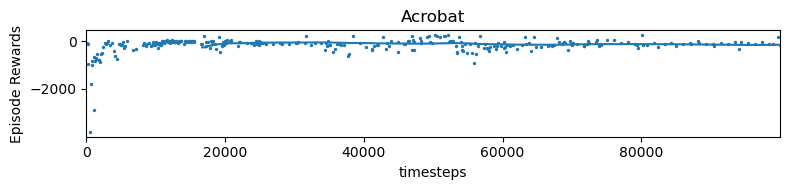

In [24]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results(
    [log_dir], 1e5, results_plotter.X_TIMESTEPS, "Acrobat"
)

In [25]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()

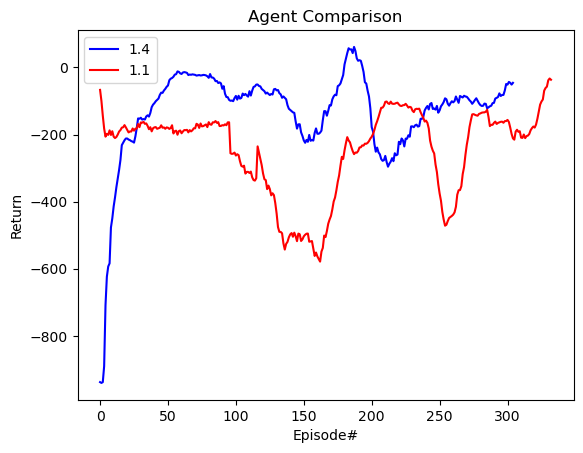

In [37]:
######## PUT YOUR CODE HERE ########

# x, y = ts2xy(load_results(log_dir), "timesteps")
# y = moving_average(y, window=20)




plt.plot(y, 'b', label='1.4')
plt.plot(agent_001.list_moving_average_returns,'r',label="1.1")

plt.ylabel('Return')
plt.xlabel('Episode#')
plt.title('Agent Comparison')
plt.legend()
plt.show()



######## PUT YOUR CODE HERE ########